# Going Deeper(CV) - 4. 이미지 어디까지 우려볼까?

다양한 Augmentation을 적용하여 비교해 보자.

---

### 루브릭 평가 기준

1. CutMix와 MixUp 기법을 ResNet50 분류기에 적용 - CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였나
2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법 찾기 - Augmentation 적용을 통해 5% 이상의 성능 향상을 확인하였나
3. 여러가지 Augmentation 기법을 적용한 결과 분석 - 기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였나

---

### 목차

0) 필요 모듈 import


1) 데이터 로드


2) Augmentation
  - 기본 Augmentation
  - CutMix
  - MixUp
  - 데이터셋 가공


3) 모델 학습


4) 결과 비교


5) 회고

## 0. 필요 모듈 import

In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. 데이터 로드

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

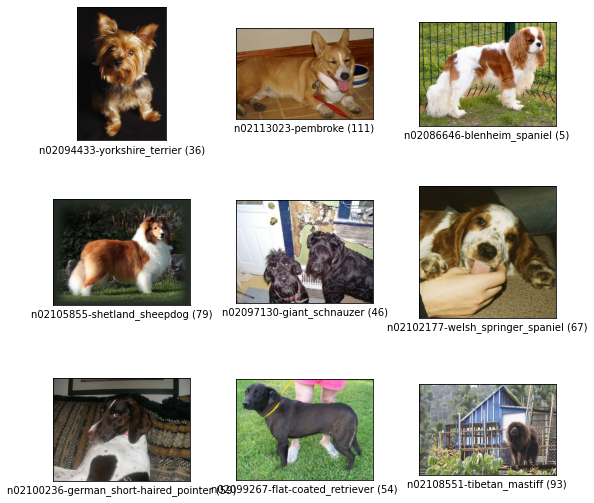

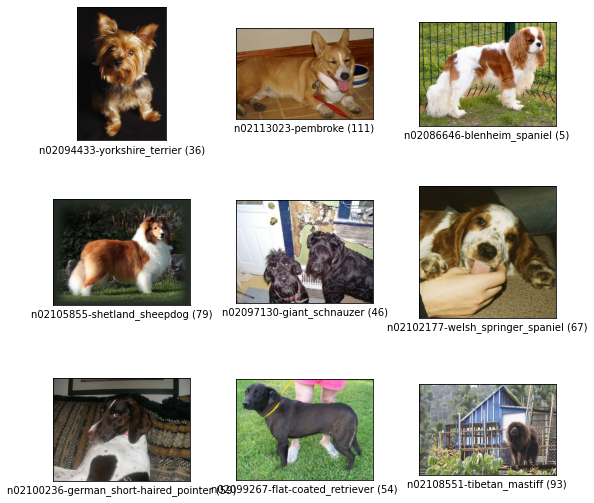

In [ ]:
tfds.show_examples(ds_train, ds_info)

## 2. Augmentation

### - 기본 Augmentation

In [ ]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [ ]:
def onehot(image, label, num_classes=120):
    label = tf.one_hot(label, num_classes)
    return image, label

무작위로 상하좌우 반전

In [ ]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image, label

무작위로 contrast, hue 조절

In [ ]:
def augment2(image,label):
    image = tf.image.random_contrast(image, 0.4, 0.6)
    image = tf.image.random_hue(image, 0.2)
    return image, label

### - Cutmix

*  이미지 섞기

In [ ]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

In [ ]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

* 라벨 섞기

In [ ]:
# mix two labels
def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [ ]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### - Mixup

In [ ]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [ ]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### - 데이터셋 가공

In [ ]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16,
                               with_aug=1, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug==1:
        ds = ds.map(
            augment
        )
    if  not is_test and with_aug==2:
        ds = ds.map(
            augment2
        )
    ds = ds.batch(batch_size)

    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug1 = apply_normalize_on_dataset(ds_train, with_aug=1)
ds_train_aug2 = apply_normalize_on_dataset(ds_train, with_aug=2)

ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

aug1, aug2 적용 결과에 따라 cutmix와 mixup을 어떤 augmentation과 함께 쓸 것인지 결정할 것이다.

## 3. 모델 학습

### - 기본 Augmentation 비교

In [ ]:
num_classes = ds_info.features["label"].num_classes

In [ ]:
# no aug
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
# aug1
aug1_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
# aug2
aug2_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
EPOCH = 20 

resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 170s 213ms/step - loss: 2.1915 - accuracy: 0.4513 - val_loss: 3.3412 - val_accuracy: 0.2113
Epoch 2/20
750/750 [==============================] - 163s 218ms/step - loss: 0.6770 - accuracy: 0.8190 - val_loss: 1.3222 - val_accuracy: 0.6203
Epoch 3/20
750/750 [==============================] - 166s 222ms/step - loss: 0.1843 - accuracy: 0.9681 - val_loss: 0.9105 - val_accuracy: 0.7308
Epoch 4/20
750/750 [==============================] - 168s 224ms/step - loss: 0.0476 - accuracy: 0.9973 - val_loss: 0.8968 - val_accuracy: 0.7400
Epoch 5/20
750/750 [==============================] - 171s 228ms/step - loss: 0.0239 - accuracy: 0.9991 - val_loss: 0.9350 - val_accuracy: 0.7312
Epoch 6/20
750/750 [==============================] - 167s 223ms/step - loss: 0.0521 - accuracy: 0.9937 - val_loss: 1.0163 - val_accuracy: 0.7175
Epoch 7/20
750/750 [==============================] - 166s 222ms/step - loss: 0.0165 - accuracy: 0.9992 - val_loss: 0.9278 -

In [ ]:
aug1_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug1 = aug1_resnet50.fit(
    ds_train_aug1, # augmentation1 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 174s 221ms/step - loss: 2.8248 - accuracy: 0.3095 - val_loss: 3.6878 - val_accuracy: 0.1545
Epoch 2/20
750/750 [==============================] - 166s 222ms/step - loss: 1.4697 - accuracy: 0.5810 - val_loss: 1.7177 - val_accuracy: 0.5204
Epoch 3/20
750/750 [==============================] - 166s 221ms/step - loss: 0.9641 - accuracy: 0.7258 - val_loss: 1.3661 - val_accuracy: 0.6031
Epoch 4/20
750/750 [==============================] - 166s 222ms/step - loss: 0.6626 - accuracy: 0.8142 - val_loss: 1.3686 - val_accuracy: 0.6229
Epoch 5/20
750/750 [==============================] - 166s 221ms/step - loss: 0.4660 - accuracy: 0.8747 - val_loss: 1.3775 - val_accuracy: 0.6193
Epoch 6/20
750/750 [==============================] - 166s 222ms/step - loss: 0.4317 - accuracy: 0.8805 - val_loss: 1.5067 - val_accuracy: 0.6061
Epoch 7/20
750/750 [==============================] - 166s 222ms/step - loss: 0.2462 - accuracy: 0.9390 - val_loss: 1.4021 -

In [ ]:
aug2_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug2 = aug2_resnet50.fit(
    ds_train_aug2, # augmentation2 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 171s 216ms/step - loss: 2.3486 - accuracy: 0.4087 - val_loss: 2.2269 - val_accuracy: 0.4146
Epoch 2/20
750/750 [==============================] - 165s 221ms/step - loss: 0.9299 - accuracy: 0.7339 - val_loss: 1.9377 - val_accuracy: 0.4886
Epoch 3/20
750/750 [==============================] - 166s 221ms/step - loss: 0.4438 - accuracy: 0.8827 - val_loss: 1.4509 - val_accuracy: 0.6111
Epoch 4/20
750/750 [==============================] - 165s 221ms/step - loss: 0.1620 - accuracy: 0.9701 - val_loss: 1.2481 - val_accuracy: 0.6600
Epoch 5/20
750/750 [==============================] - 166s 221ms/step - loss: 0.0549 - accuracy: 0.9957 - val_loss: 1.1366 - val_accuracy: 0.6877
Epoch 6/20
750/750 [==============================] - 166s 221ms/step - loss: 0.0331 - accuracy: 0.9976 - val_loss: 1.1839 - val_accuracy: 0.6865
Epoch 7/20
750/750 [==============================] - 166s 222ms/step - loss: 0.0171 - accuracy: 0.9993 - val_loss: 1.1606 -

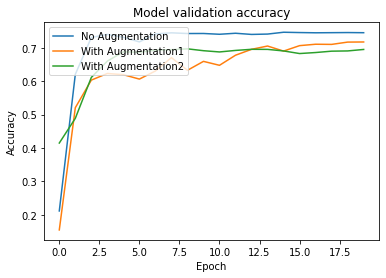

In [ ]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'])
plt.plot(history_resnet50_aug1.history['val_accuracy'])
plt.plot(history_resnet50_aug2.history['val_accuracy'])
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation1', 'With Augmentation2'], loc='upper left')
plt.show()

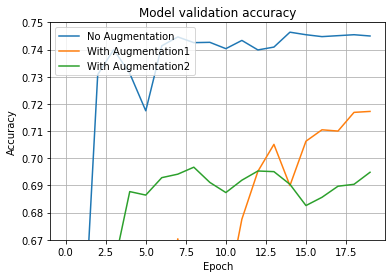

In [ ]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'])
plt.plot(history_resnet50_aug1.history['val_accuracy'])
plt.plot(history_resnet50_aug2.history['val_accuracy'])
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation1', 'With Augmentation2'], loc='upper left')
plt.grid(True)
plt.ylim(0.67, 0.75)
plt.show()

contrast와 hue를 조절한 aug2보다 상하좌우를 반전시킨 aug1를 적용한 데이터에 대한 학습 결과가 더 좋은 것을 볼 수 있다.

### - cutmix, mixup 적용 데이터 학습

위의 과정에서 aug1을 적용한 데이터의 학습 결과가 더 좋은 것을 확인하였다.  
aug1과 cutmix, mixup을 함께 적용한 데이터로 학습을 진행해 보자. 

In [ ]:
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug=1, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=1, with_mixup=True)

In [ ]:
# cutmix
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
# mixup
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # cutmix 적용 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 173s 212ms/step - loss: 4.1424 - accuracy: 0.1355 - val_loss: 3.9909 - val_accuracy: 0.1207
Epoch 2/20
750/750 [==============================] - 165s 220ms/step - loss: 3.3361 - accuracy: 0.3136 - val_loss: 1.7886 - val_accuracy: 0.5007
Epoch 3/20
750/750 [==============================] - 166s 222ms/step - loss: 3.0672 - accuracy: 0.3890 - val_loss: 1.4060 - val_accuracy: 0.5993
Epoch 4/20
750/750 [==============================] - 168s 224ms/step - loss: 2.9099 - accuracy: 0.4375 - val_loss: 1.6485 - val_accuracy: 0.5529
Epoch 5/20
750/750 [==============================] - 166s 222ms/step - loss: 2.7498 - accuracy: 0.4832 - val_loss: 1.5224 - val_accuracy: 0.5824
Epoch 6/20
750/750 [==============================] - 166s 222ms/step - loss: 2.6361 - accuracy: 0.5158 - val_loss: 1.3715 - val_accuracy: 0.6196
Epoch 7/20
750/750 [==============================] - 167s 222ms/step - loss: 2.5324 - accuracy: 0.5512 - val_loss: 1.5452 -

In [ ]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # mixup 적용 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 174s 219ms/step - loss: 4.0840 - accuracy: 0.1476 - val_loss: 4.3699 - val_accuracy: 0.0702
Epoch 2/20
750/750 [==============================] - 167s 223ms/step - loss: 3.2937 - accuracy: 0.3363 - val_loss: 1.9324 - val_accuracy: 0.4689
Epoch 3/20
750/750 [==============================] - 166s 222ms/step - loss: 3.0575 - accuracy: 0.4078 - val_loss: 1.5443 - val_accuracy: 0.5634
Epoch 4/20
750/750 [==============================] - 166s 222ms/step - loss: 2.8536 - accuracy: 0.4752 - val_loss: 1.9125 - val_accuracy: 0.4972
Epoch 5/20
750/750 [==============================] - 166s 222ms/step - loss: 2.7213 - accuracy: 0.5191 - val_loss: 1.5265 - val_accuracy: 0.5794
Epoch 6/20
750/750 [==============================] - 166s 222ms/step - loss: 2.6366 - accuracy: 0.5561 - val_loss: 1.3072 - val_accuracy: 0.6336
Epoch 7/20
750/750 [==============================] - 167s 222ms/step - loss: 2.5444 - accuracy: 0.5896 - val_loss: 1.4474 -

## 4. 결과 비교

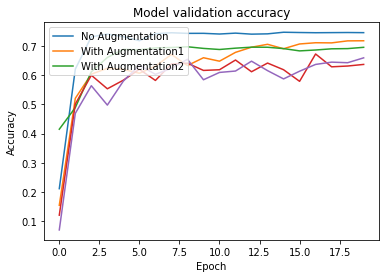

In [ ]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'])
plt.plot(history_resnet50_aug1.history['val_accuracy'])
plt.plot(history_resnet50_aug2.history['val_accuracy'])
plt.plot(history_resnet50_cutmix.history['val_accuracy'])
plt.plot(history_resnet50_mixup.history['val_accuracy'])
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation1', 'With Augmentation2'], loc='upper left')
plt.show()

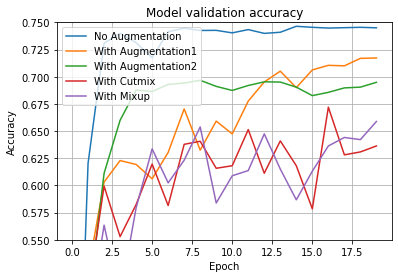

In [ ]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'])
plt.plot(history_resnet50_aug1.history['val_accuracy'])
plt.plot(history_resnet50_aug2.history['val_accuracy'])
plt.plot(history_resnet50_cutmix.history['val_accuracy'])
plt.plot(history_resnet50_mixup.history['val_accuracy'])
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation1', 'With Augmentation2', 'With Cutmix', 'With Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.55, 0.75)
plt.show()

아무 기법도 적용하지 않은 데이터셋에 대한 결과가 가장 좋게 나왔다.  
augmentation이 학습 성능 향상에 도움이 되지 않았음을 알 수 있다.  
원본 데이터와 augmentation을 적용한 데이터를 함께 사용하여 데이터의 다양성을 확보하고 과적합을 방지하는 역할을 할 수 있도록 해야하는데,  
변형된 이미지만을 사용하여 학습을 진행하여 오히려 혼란을 야기한 것 같다.  
augmentation을 적용하고 데이터의 수를 부풀려 사용할 수 있도록 한다면 더 좋은 성능을 기대할 수 있을 것 같다.   
노드에 나온 방식대로 데이터를 사용했다면 루브릭 기준인 5% 이상의 성능 향상은 절대 볼 수 없을 것이다.

## 5. 회고

#### - 학습 흔적이 사라졌다!!!

학습을 모두 진행하고 회고를 쓰기 위해 코랩에서 노트북을 다시 열었더니 In[1]과 같은 흔적이 다 사라졌다......  
출력 결과는 남아있어 다행이지만 아직도 코랩이 너무너무 어렵다.


#### - 시간을 여유롭게

Going Deeper에 들어오면서 학습 시간이 상당히 많이 필요한 프로젝트를 수행하게 된다.  
한참을 기다려서 학습을 했다가 다음 과정에서 오류가 발생해 다시 처음부터 하게 되는 경우도 있는데, 이렇게 되면 예상했던 것 보다 훨씬 많은 시간을 투자하게 된다.  
미리미리 프로젝트를 시작하여 시간을 좀 여유롭게 가져가야겠다고 다시 한 번 느낀다.